# Climate Claim Classification: Zero-Shot vs. Few-Shot Learning

This notebook demonstrates and compares two advanced Natural Language Processing (NLP) paradigms – **Zero-Shot Learning (ZSL)** and **Few-Shot Learning (FSL)** – for the task of classifying climate-related claims. 

The goal is to distinguish between claims that are 'related' to climate change and those that are 'not_related'.


## Table of Contents
1.  [Data Loading and Preparation](#1.-Data-Loading-and-Preparation)
2.  [Zero-Shot Learning (ZSL) with NLI](#2.-Zero-Shot-Learning-(ZSL)-with-NLI)
3.  [Few-Shot Learning (FSL) with SetFit](#3.-Few-Shot-Learning-(FSL)-with-SetFit)
4.  [Visualization: Confusion Matrices](#4.-Visualization:-Confusion-Matrices)

In [1]:
import pandas as pd
from datasets import load_dataset, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from setfit import SetFitModel, SetFitTrainer, sample_dataset

## 1. Data Loading and Preparation

In [2]:
# --- 1. Load and Prepare Dataset ---
print("Loading 'mwong/climate-claim-related' dataset...")
dataset = load_dataset("mwong/climate-claim-related")
full_dataset = dataset['train']


# Define label mapping for the identified classes
labels_map = {0: 'related', 1: 'not_related'}
candidate_labels = list(labels_map.values())

df = full_dataset.to_pandas()
df['label_name'] = df['labels'].map(labels_map)

print("Actual labels in the full dataset:", df['label_name'].unique())

# --- Create Test Set and Training Pool (Stratified Sampling) ---
# We create a stratified test set to ensure balanced representation of each class.
# For each unique label, we sample up to 150 instances (or fewer if not enough are available).
sampled_dfs = []
for label in df['label_name'].unique():
    group = df[df['label_name'] == label]
    sample_size = min(len(group), 150)
    sampled_dfs.append(group.sample(n=sample_size, random_state=42))

test_df = pd.concat(sampled_dfs)

# Extract claims and true labels for the test set
test_claims = test_df['claim'].tolist()
y_true = test_df['label_name'].tolist()

# The remaining data forms our training pool for Few-Shot Learning
train_df = df.drop(test_df.index)

print(f"Dataset loaded. Test set size: {len(test_df)}")
print(f"Training pool size: {len(train_df)}")

Loading 'mwong/climate-claim-related' dataset...
Actual labels in the full dataset: ['not_related' 'related']
Dataset loaded. Test set size: 300
Training pool size: 11980


## 2. Zero-Shot Learning (ZSL) with NLI

In [3]:
print("Running Zero-Shot Learning classification...")
zsl_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

zsl_preds_raw = zsl_classifier(test_claims, candidate_labels=candidate_labels, multi_label=False)
y_pred_zsl = [pred['labels'][0] for pred in zsl_preds_raw]

print("\n--- Zero-Shot Learning Results ---")
print(classification_report(y_true, y_pred_zsl, labels=candidate_labels))

Running Zero-Shot Learning classification...


Device set to use mps:0



--- Zero-Shot Learning Results ---
              precision    recall  f1-score   support

     related       0.51      1.00      0.67       150
 not_related       1.00      0.02      0.04       150

    accuracy                           0.51       300
   macro avg       0.75      0.51      0.36       300
weighted avg       0.75      0.51      0.36       300



## 3. Few-Shot Learning (FSL) with SetFit

In [4]:
print("\nRunning Few-Shot Learning classification...")

# Prepare data for SetFit: it expects columns 'text' and 'label'.
train_df_for_fsl = train_df.rename(columns={'claim': 'text', 'labels': 'label'})
train_dataset_for_fsl = Dataset.from_pandas(train_df_for_fsl[['text', 'label']])

# Sample 8 examples per class for training the SetFit model
train_dataset_8shot = sample_dataset(train_dataset_for_fsl, label_column="label", num_samples=8)

# Load a pre-trained Sentence Transformer model as the base for SetFit
fsl_model = SetFitModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Initialize the SetFit trainer
trainer = SetFitTrainer(
    model=fsl_model,
    train_dataset=train_dataset_8shot,
    metric="accuracy",
    batch_size=8,
    num_iterations=100,
    num_epochs=5
)

# Train the SetFit model
trainer.train()

# Make predictions on the test set
fsl_predictions_numeric = trainer.model.predict(test_claims)

# Convert tensor predictions to integers before mapping back to label names
y_pred_fsl = [labels_map[label.item()] for label in fsl_predictions_numeric]

print("\n--- Few-Shot Learning (8-shot) Results ---")
print(classification_report(y_true, y_pred_fsl, labels=candidate_labels))


Running Few-Shot Learning classification...


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/vd/tdjtsvvd6n9570nygscfprww0000gn/T/ipykernel_81189/386021113.py:14: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 3200
  Batch size = 8
  Num epochs = 5
/Users/alexmolin/dsdm/forecasting_and_nowcasting/hw2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.375700
50,0.274400
100,0.234500
150,0.159900
200,0.024400
250,0.003400
300,0.002200
350,0.001700
400,0.001200
450,0.001000


/Users/alexmolin/dsdm/forecasting_and_nowcasting/hw2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/alexmolin/dsdm/forecasting_and_nowcasting/hw2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/alexmolin/dsdm/forecasting_and_nowcasting/hw2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Few-Shot Learning (8-shot) Results ---
              precision    recall  f1-score   support

     related       0.53      0.82      0.64       150
 not_related       0.59      0.26      0.36       150

    accuracy                           0.54       300
   macro avg       0.56      0.54      0.50       300
weighted avg       0.56      0.54      0.50       300



## 4. Visualization: Confusion Matrices


Generating confusion matrices...


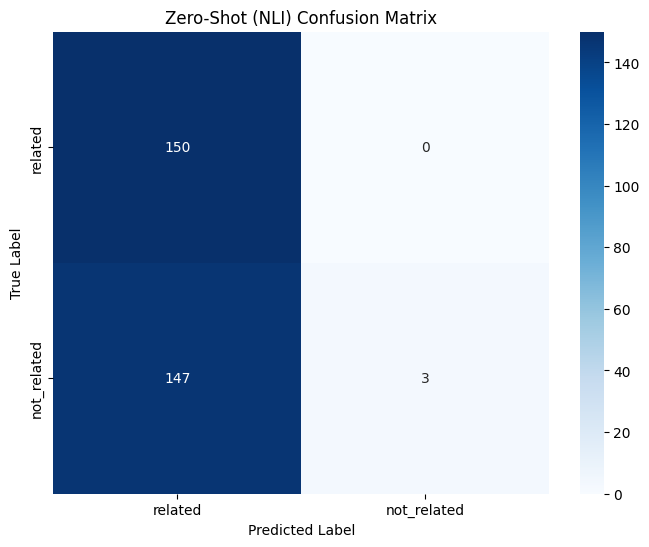

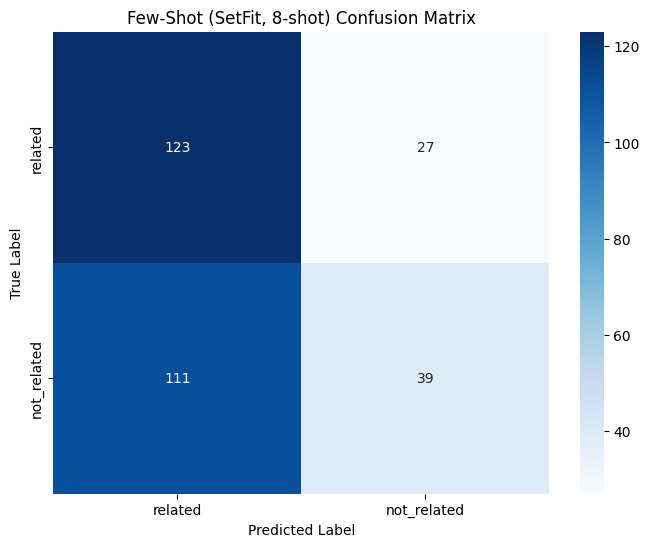

In [5]:
# Function to plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred, title, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

print("\nGenerating confusion matrices...")

# Generate confusion matrix for Zero-Shot Learning
plot_confusion_matrix(y_true, y_pred_zsl,
                      title='Zero-Shot (NLI) Confusion Matrix',
                      labels=candidate_labels)

# Generate confusion matrix for Few-Shot Learning
plot_confusion_matrix(y_true, y_pred_fsl,
                      title='Few-Shot (SetFit, 8-shot) Confusion Matrix',
                      labels=candidate_labels)